# Chapter 2: Consensus Expected Returns, the CAPM

### Separating Returns

- The CAPM relies on two constructs: a market portfolio $M$ and beta $\beta$ which links the portfolio to the market.
- In theory $M$ contains all assets, but in practice we take it as a broad value-weighted index of traded domestic equities.

Suppose we have a portfolio $P$ with excess returns $r_{p}$ and the market portfolio $M$ with excess returns $r_{m}$. Then the beta of portfolio $P$ is equal to:

$$ \beta_{P} = \frac{Cov(r_{P},r_{M})}{Var(r_{M})} $$

The simplest estimate of $\beta_{P}$ comes from a linear regression of portfolio excess returns $r_{P}(t)$ on market excess returns $r_{M}(t)$ in the same period:

$$ r_{P}(t) = \alpha_{P} + \beta_{P}r_{M}(t) + \epsilon_{P}(t)  $$

These are realized or historical betas and alphas. These can be used for reasonable forecasts in the future, but evidence from Rosenberg (1985) suggests that betas tend to regress to the mean, so Bayesian analysis may be applicable here.

Beta is a way of separating risk and return into two parts : a market component and a residual component:

$$ r_{P} = \beta_{P}r_{M} + \theta_{P} $$

The residual return $\theta_{P}$ will be uncorrelated with the market return $r_{M}$ and so the variance of portfolio $P$ is:

$$ \sigma_{P}^{2} = \beta^{2}_{P}\sigma_{M}^{2} + \omega_{P}^{2} $$

Where $\omega_{P}^{2}$ is the residual variance of the portfolio.

The **CAPM** states that the expected residual return on all stocks and any portfolio is equal to zero, i.e. $E[\theta_{P}]=0$. Therefore the expected excess return on the portfolio $E[r_{P}]=\mu_{P}$ is determined entirely by the expected excess return on the market, $E[r_{M}]=\mu_{M}$ and the portfolio $\beta$, i.e:

$$ E[r_{P}] = \beta_{P}E[r_{M}] =  \beta_{P}\mu_{M} $$

#### Python Example

We will use the S&P500 as 'the market', Macy's (**M**) as an example stock, and the 1-month Treasury bill as the risk-free rate (we convert the rate to daily returns). First we load libraries:

First we will load data on the S&P500 (the market) for the period 2012-2014. We'll use data for the SPY ETF:

In [4]:
import numpy as np
import pandas as pd
from pandas.io.data import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline 

First we load data on the risk-free rate and convert to daily returns:

In [29]:
one_mon = DataReader('DGS1MO', 'fred',datetime(2012,1,1), datetime(2015,1,1))
one_day = np.log(1+one_mon)/30

Next we load details on S&P500 returns:

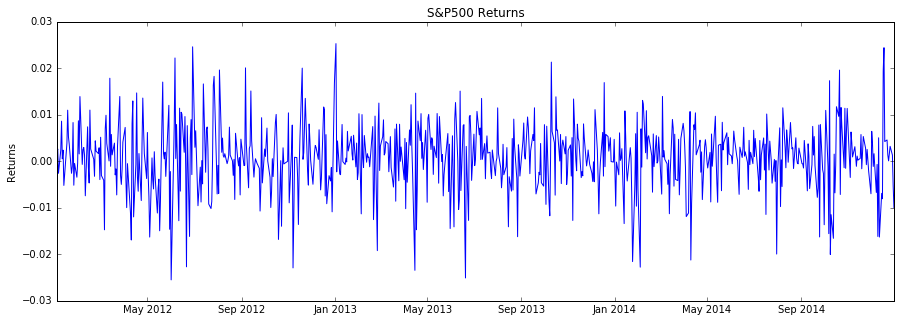

In [82]:
spy = DataReader('SPY',  'yahoo', datetime(2012,1,1), datetime(2015,1,1))
spy_returns = pd.DataFrame(np.diff(np.log(spy['Adj Close'].values)))
spy_returns.index = spy.index.values[1:spy.index.values.shape[0]]
spy_returns.columns = ['S&P500 Returns']

plt.figure(figsize=(15,5));
plt.plot(spy_returns);
plt.ylabel('Returns');
plt.title('S&P500 Returns');
plt.show();

We'll calculate returns an example stock that's listed on this index - for example, Macy's (**M**):

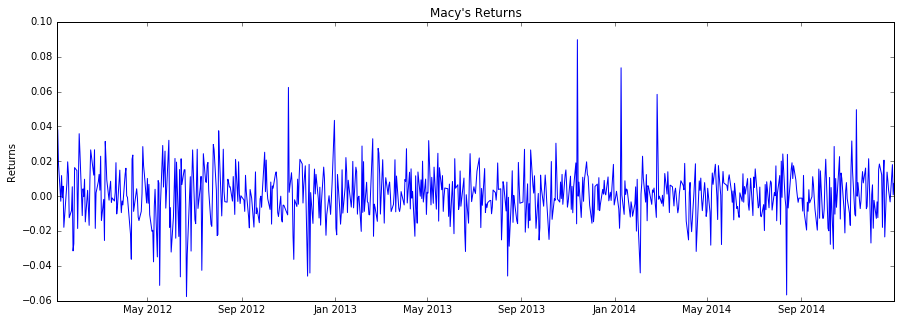

In [83]:
m = DataReader('M',  'yahoo', datetime(2012,1,1), datetime(2015,1,1))
m_returns = pd.DataFrame(np.diff(np.log(m['Adj Close'].values)))
m_returns.index = spy.index.values[1:m.index.values.shape[0]]
m_returns.columns = ["Macy's Returns"]

plt.figure(figsize=(15,5));
plt.plot(m_returns);
plt.ylabel('Returns');
plt.title("Macy's Returns");
plt.show();

Next we need to merge the series to make sure they are all on the same timescale and then calculate the excess returns:

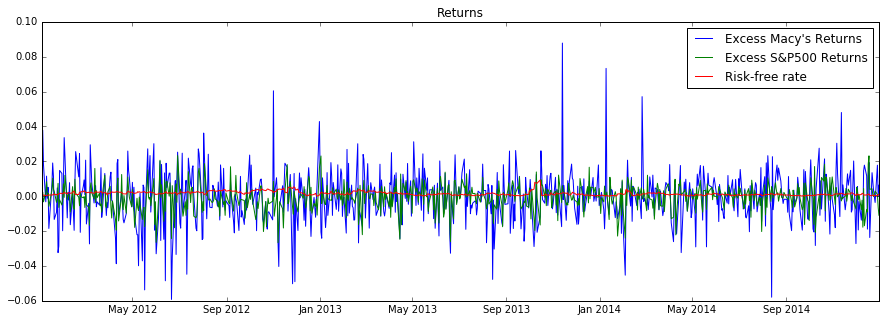

In [119]:
returns = pd.concat([one_day,m_returns,spy_returns],axis=1).dropna()
excess_m = returns["Macy's Returns"].values - returns['DGS1MO'].values
excess_spy = returns["S&P500 Returns"].values - returns['DGS1MO'].values
final_returns = pd.DataFrame(np.transpose([excess_m,excess_spy, returns['DGS1MO'].values]))
final_returns.columns=["Excess Macy's Returns","Excess S&P500 Returns","Risk-free rate"]
final_returns.index = returns.index

plt.figure(figsize=(15,5))
plt.title("Returns")
x = plt.plot(final_returns);
plt.legend(iter(x), final_returns.columns);

Now we will perform a linear regression using the two series:

In [120]:
import statsmodels.api as sm

exog = excess_spy
exog = sm.add_constant(exog, prepend=True)
mod = sm.OLS(excess_m, exog)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     254.0
Date:                Fri, 13 May 2016   Prob (F-statistic):           2.00e-49
Time:                        12:00:45   Log-Likelihood:                 2175.6
No. Observations:                 747   AIC:                            -4347.
Df Residuals:                     745   BIC:                            -4338.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0004      0.000      0.729      0.4

From this $\beta_{M}=1.0312$ and $\alpha=0.0004$, although the latter is not statistically significant - this is consistent with CAPM which predicts no excess expected residual returns.

Using these results we can split the excess returns into the market component and residual component:

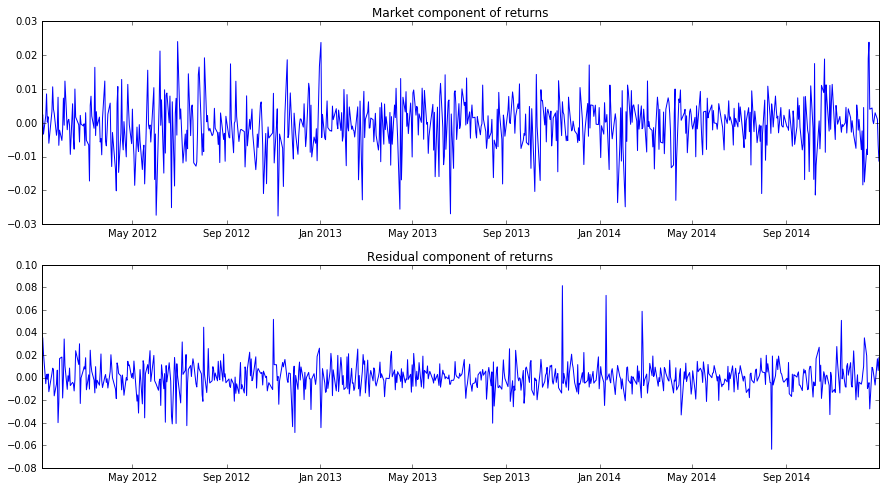

In [135]:
market_c = excess_spy*1.0312
residual_c = excess_m - market_c

plt.figure(figsize=(15,8))
plt.subplot(211)
plt.title("Market component of returns");
plt.plot(final_returns.index,market_c);
plt.subplot(212)
plt.title("Residual component of returns");
plt.plot(final_returns.index,residual_c);